In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import cv2
from glob import glob
from keras import backend as K
import keras
from keras.layers import Dense,Input,Conv2D,MaxPooling2D,Activation,Flatten,Dropout,Cropping2D,Lambda,GlobalAveragePooling2D,BatchNormalization,AveragePooling2D
from keras.models import Sequential,Model
from keras.optimizers import SGD,rmsprop
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

from keras.metrics import (categorical_accuracy, categorical_crossentropy,
                           top_k_categorical_accuracy)
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import hamming_loss
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report

import imutils
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.
c:\users\mbura\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\mbura\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\mbura\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
train_files = "C:/Users/mbura/Desktop/EE492/Dataset/train/"
test_files =  "C:/Users/mbura/Desktop/EE492/Dataset/test/"

In [12]:
labels = [paths.split("\\")[-1] for paths in glob(train_files + "*")]

## **Best Model: DenseNet121**

In [3]:
BS = 32
SIZE = 224
TEST_SIZE = 0.1

In [4]:
base_model = MobileNetV2(include_top=False, weights='imagenet',
                         input_shape=(SIZE, SIZE, 3), classes=20)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(.2)(x)

predictions = Dense(20, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


for layer in model.layers:  
    layer.trainable = True

model.compile(optimizer=Adam(lr=1e-3, decay=1e-9), loss="categorical_crossentropy", metrics=['accuracy'])


In [5]:
callbacks = [EarlyStopping(patience=3, verbose=1),
            ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)]

In [6]:
train_datagen = ImageDataGenerator(
                preprocessing_function = preprocess_input,
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest')

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_files,
        target_size=(SIZE, SIZE),
        batch_size=BS,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        test_files,
        target_size = (SIZE, SIZE),
        batch_size = BS,
        class_mode='categorical')


H = model.fit_generator(train_generator,
                        shuffle=True,
                        workers = -1,
                        validation_data = validation_generator, 
                        validation_steps = 12443 // BS,
                        callbacks = callbacks, 
                        steps_per_epoch = 49007 // BS,
                        epochs = 5)

Found 49007 images belonging to 20 classes.
Found 12443 images belonging to 20 classes.
Epoch 1/5
1531/1531 [==============================] - 2000s 1s/step - loss: 0.3035 - acc: 0.8927 - val_loss: 2.1175 - val_acc: 0.6100
Epoch 2/5
1531/1531 [==============================] - 1805s 1s/step - loss: 0.1465 - acc: 0.9493 - val_loss: 1.0761 - val_acc: 0.7377
Epoch 3/5
1531/1531 [==============================] - 1810s 1s/step - loss: 0.1153 - acc: 0.9598 - val_loss: 2.6812 - val_acc: 0.5883
Epoch 4/5
1531/1531 [==============================] - 1806s 1s/step - loss: 0.1019 - acc: 0.9665 - val_loss: 7.7139 - val_acc: 0.2473
Epoch 5/5
1531/1531 [==============================] - 1763s 1s/step - loss: 0.0851 - acc: 0.9714 - val_loss: 0.2445 - val_acc: 0.9331


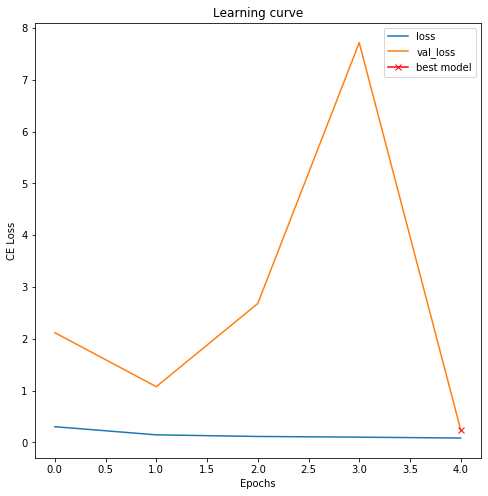

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(H.history["loss"], label="loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot( np.argmin(H.history["val_loss"]), np.min(H.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("CE Loss")
plt.legend()

In [32]:
filenames = validation_generator.filenames
nb_samples = len(filenames)
nb_samples

12443

In [147]:
validation_generator = test_datagen.flow_from_directory(
        test_files,
        target_size = (SIZE, SIZE),
        batch_size = 1,
        class_mode='categorical',
        shuffle = False)

Found 12443 images belonging to 20 classes.


In [241]:
X_val = cv2.imread("C:/Users/mbura/Desktop/EE492/Dataset/test/cheetos_biftek/vid0_0.jpg")

In [242]:
X_val = cv2.cvtColor(X_val, cv2.COLOR_RGB2BGR)


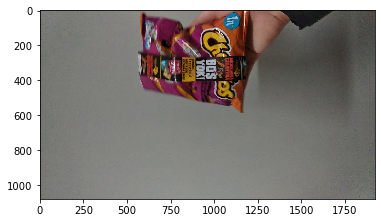

In [243]:
plt.imshow(X_val)

In [244]:
X_val = cv2.resize(X_val, (SIZE, SIZE))
X_val = preprocess_input(X_val)

In [246]:
%%timeit
y_pred = np.rint(model.predict(X_val.reshape(1,224,224,3)))

9.15 ms ± 616 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [245]:
y_pred_labels = [inv_map[np.argmax(pred_, axis = -1)] for pred_ in y_pred]
y_pred_labels

['cheetos_biftek']

In [162]:
import time

t1 = time.time()
predict = model.predict_generator(validation_generator,steps = 1)
time.time()-t1

0.10312986373901367

In [161]:
predict.shape

(1, 20)

In [93]:
y_pred = np.rint(predict)
y_true = validation_generator.classes[:len(y_pred)]

In [94]:
inv_map = {v: k for k, v in validation_generator.class_indices.items()} 

In [95]:
y_pred_labels = [inv_map[np.argmax(pred_, axis = -1)] for pred_ in y_pred]
y_true_labels = [inv_map[pred_] for pred_ in y_true]

In [96]:
print(classification_report(y_true_labels, y_pred_labels))

                   precision    recall  f1-score   support

   cheetos_biftek       0.89      1.00      0.94       627
   cheetos_peynir       0.99      1.00      0.99       617
            cola1       0.97      0.22      0.36       627
           cola15       0.58      0.96      0.72       630
        cola_kutu       1.00      0.98      0.99       606
        cola_sise       0.86      1.00      0.92       624
    colazero_sise       0.99      0.97      0.98       603
          doritos       0.98      0.98      0.98       633
           lipton       1.00      1.00      1.00       614
  nescafe_classic       0.96      0.99      0.98       622
     nescafe_gold       1.00      1.00      1.00       619
       pepsi_kutu       0.96      0.99      0.98       614
            pinar       0.99      0.99      0.99       624
          redbull       0.99      0.93      0.96       603
   ruffles_ketcap       0.85      0.95      0.89       623
   ruffles_peynir       0.97      0.79      0.87       

In [18]:
import json

## Save weights & model structure:

model.save_weights('MobileNetv2_train1.h5')

model_json = model.to_json()
with open("MobileNetv2_train1.json", "w") as json_file:
    json.dump(model_json, json_file)

In [ ]:
# from keras.models import load_model
# from keras.models import model_from_json
# import json

# ## Reload weights & model structure:

# with open('model_in_json.json','r') as f:
#     model_json = json.load(f)

# model = model_from_json(model_json)
# model.load_weights('model.h5')
